## Linear Regression Model

En este notebook se va a analizar un dataset con datos de vehículos de segunda mano y su precio en venta. 
Se van a entrenar varios modelos de regresión lineal para escoger el más óptimo y guardarlo para poder ponerlo

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sn
import numpy as np
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

### Lectura de los datos

In [6]:
data3 = pd.read_csv("Car details v3.csv")

In [7]:
data3.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.00
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.00
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.00


In [8]:
# Transforme the price to euros for better understanding

data3["selling_price"] = data3["selling_price"] * .012

In [9]:
data3["mileage_num"] = data3.mileage.str.extract('([+-]?[0-9]*[.]?[0-9]+)').astype(float)
data3["engine_num"] = data3.engine.str.extract('([+-]?[0-9]*[.]?[0-9]+)').astype(float)
data3["max_power_num"] = data3.max_power.str.extract('([+-]?[0-9]*[.]?[0-9]+)').astype(float)
data3["torque_num"] = data3.torque.str.extract('([0-9]*[.]?[0-9]+(?=\s*Nm))').astype(float)
data3["torque_rpm"] = data3.torque.str.extract('([0-9]*[.]?[0-9]+(?=\s*rpm))').astype(float)

### Transformación y creación de variables

In [10]:
# Transform year variable to age
data3["year"] = 2021 - data3["year"]

# Extract brand of the car from name
data3["brand"] = data3.name.str.split(" ").apply(lambda x: x[0])

# Transform categorical features
transmission = data3.pivot_table(index=data3.index,columns="transmission", 
                                 values="selling_price", aggfunc=lambda x: len(x.unique())).fillna(0)
fuel = data3.pivot_table(index=data3.index,columns="fuel", 
                                 values="selling_price", aggfunc=lambda x: len(x.unique())).fillna(0)
seller_type = data3.pivot_table(index=data3.index,columns="seller_type", 
                                 values="selling_price", aggfunc=lambda x: len(x.unique())).fillna(0)
brand = data3.pivot_table(index=data3.index,columns="brand", 
                                 values="selling_price", aggfunc=lambda x: len(x.unique())).fillna(0)
data3 = data3.join(transmission).join(fuel).join(seller_type).join(brand)

#Owner directly to numeric
owner_dict = {"First Owner": 1, "Second Owner": 2, "Third Owner": 3, "Fourth & Above Owner": 4, "Test Drive Car": 0}
data3 = data3.replace({"owner": owner_dict})



In [11]:
# Delete categorical features
data3 = data3.drop(["name","transmission", "fuel", "seller_type", "brand", "mileage", "torque", "engine", "max_power"], axis=1)

In [12]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data3.describe()

,year,selling_price,km_driven,owner,seats,mileage_num,engine_num,max_power_num,torque_num,torque_rpm,Automatic,Manual,CNG,Diesel,LPG,Petrol,Dealer,Individual,Trustmark Dealer,Ambassador,Ashok,Audi,BMW,Chevrolet,Daewoo,Datsun,Fiat,Force,Ford,Honda,Hyundai,Isuzu,Jaguar,Jeep,Kia,Land,Lexus,MG,Mahindra,Maruti,Mercedes-Benz,Mitsubishi,Nissan,Opel,Peugeot,Renault,Skoda,Tata,Toyota,Volkswagen,Volvo
count,8128.00,8128.00,8128.00,8128.00,7907.00,7907.00,7907.00,7912.00,7133.00,7449.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00
mean,7.20,7659.26,69819.51,1.46,5.42,19.42,1458.63,91.52,178.01,3059.41,0.13,0.87,0.01,0.54,0.00,0.45,0.14,0.83,0.03,0.00,0.00,0.00,0.01,0.03,0.00,0.01,0.01,0.00,0.05,0.06,0.17,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.09,0.30,0.01,0.00,0.01,0.00,0.00,0.03,0.01,0.09,0.06,0.02,0.01
std,4.04,9675.04,56550.55,0.72,0.96,4.04,503.92,35.82,92.58,940.37,0.34,0.34,0.08,0.50,0.07,0.50,0.35,0.37,0.17,0.02,0.01,0.07,0.12,0.17,0.02,0.09,0.08,0.03,0.22,0.23,0.38,0.02,0.09,0.06,0.02,0.03,0.06,0.02,0.29,0.46,0.08,0.04,0.10,0.01,0.01,0.17,0.11,0.29,0.24,0.15,0.09
min,1.00,359.99,1.00,0.00,2.00,0.00,624.00,0.00,48.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.00,3059.99,35000.00,1.00,5.00,16.78,1197.00,68.05,110.00,2250.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,6.00,5400.00,60000.00,1.00,5.00,19.30,1248.00,82.00,171.00,3000.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,10.00,8100.00,98000.00,2.00,5.00,22.32,1582.00,102.00,205.00,4000.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,38.00,120000.00,2360457.00,4.00,14.00,42.00,3604.00,400.00,789.00,5300.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Limpieza del dataset

##### Valores nulos

In [13]:
data3.isnull().sum()

year                  0
selling_price         0
km_driven             0
owner                 0
seats               221
mileage_num         221
engine_num          221
max_power_num       216
torque_num          995
torque_rpm          679
Automatic             0
Manual                0
CNG                   0
Diesel                0
LPG                   0
Petrol                0
Dealer                0
Individual            0
Trustmark Dealer      0
Ambassador            0
Ashok                 0
Audi                  0
BMW                   0
Chevrolet             0
Daewoo                0
Datsun                0
Fiat                  0
Force                 0
Ford                  0
Honda                 0
Hyundai               0
Isuzu                 0
Jaguar                0
Jeep                  0
Kia                   0
Land                  0
Lexus                 0
MG                    0
Mahindra              0
Maruti                0
Mercedes-Benz         0
Mitsubishi      

Como el número de registros nulos es bajo para las variables originales, vamos a sustituir los nulos por ceros, 
si el modelo no diese un resultado satisfactorio se podría revisar este punto

In [14]:
data3 = data3.fillna(0)

##### Outliers

Calculamos el histograma de las variables cuantitativas

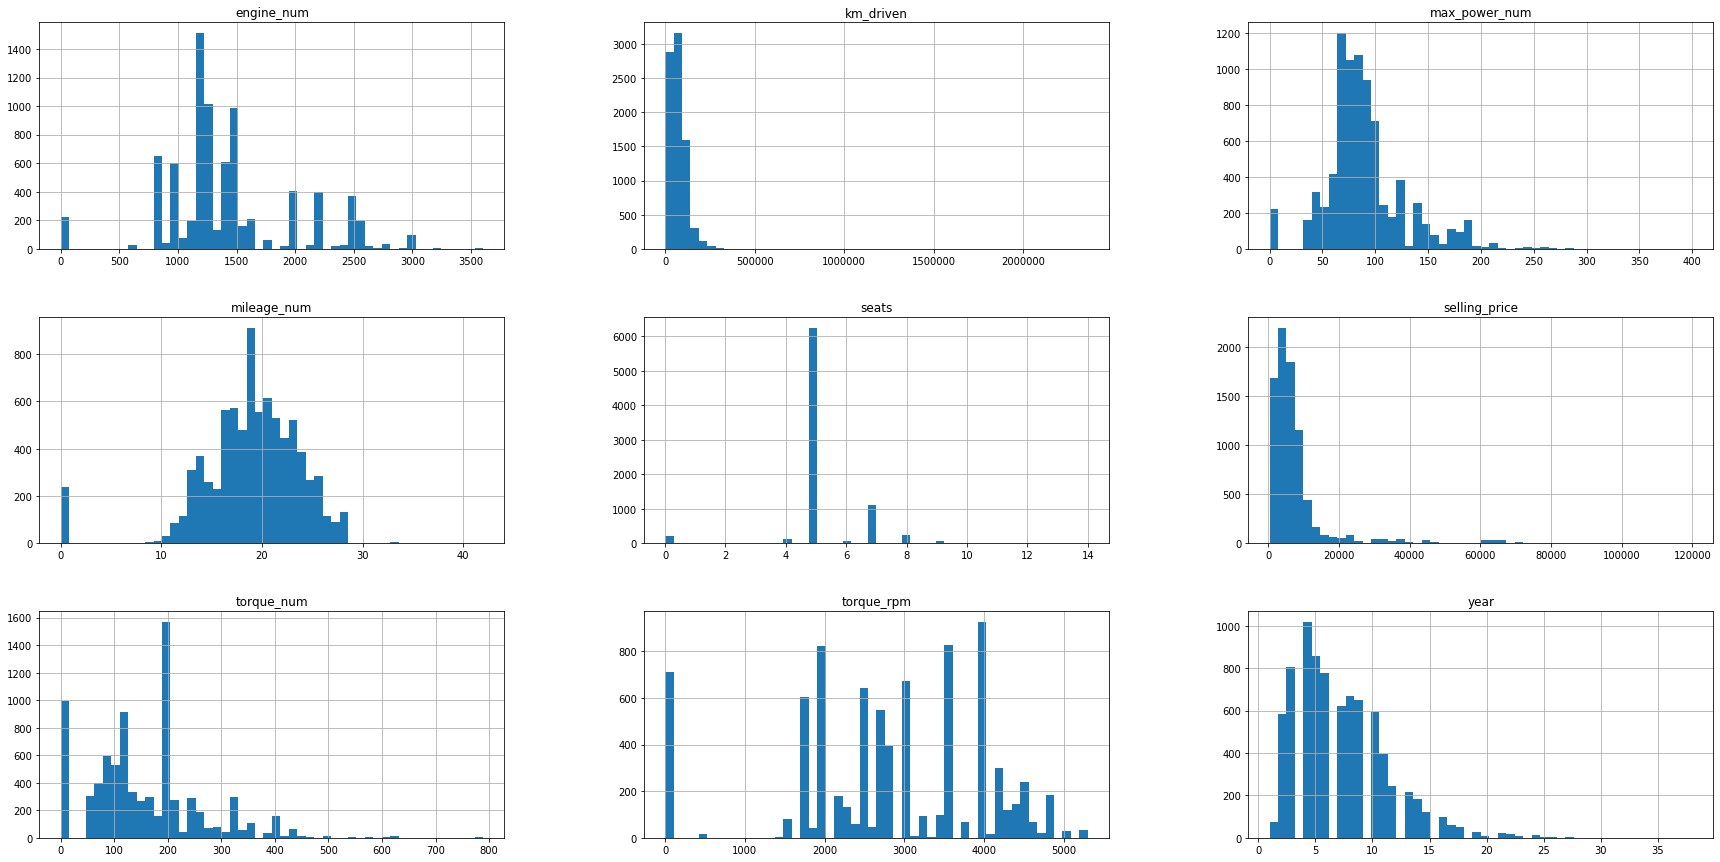

In [15]:
%matplotlib inline
data3[["year", "selling_price", "km_driven", "seats", "mileage_num", "engine_num", "max_power_num",
       "torque_num", "torque_rpm"]].hist(bins=50, figsize=(30,15))
plt.show()

Eliminamos por variable:
    - km_driven: Los que tienen más de 300k kilómetros.
    - selling_price: Los que se venden por más de 50k.
    - seats: El coche con 14 plazas, ningún coche de la marca Tata es tan grande.

El resto de variables consideramos que tienen una distribución adecuada

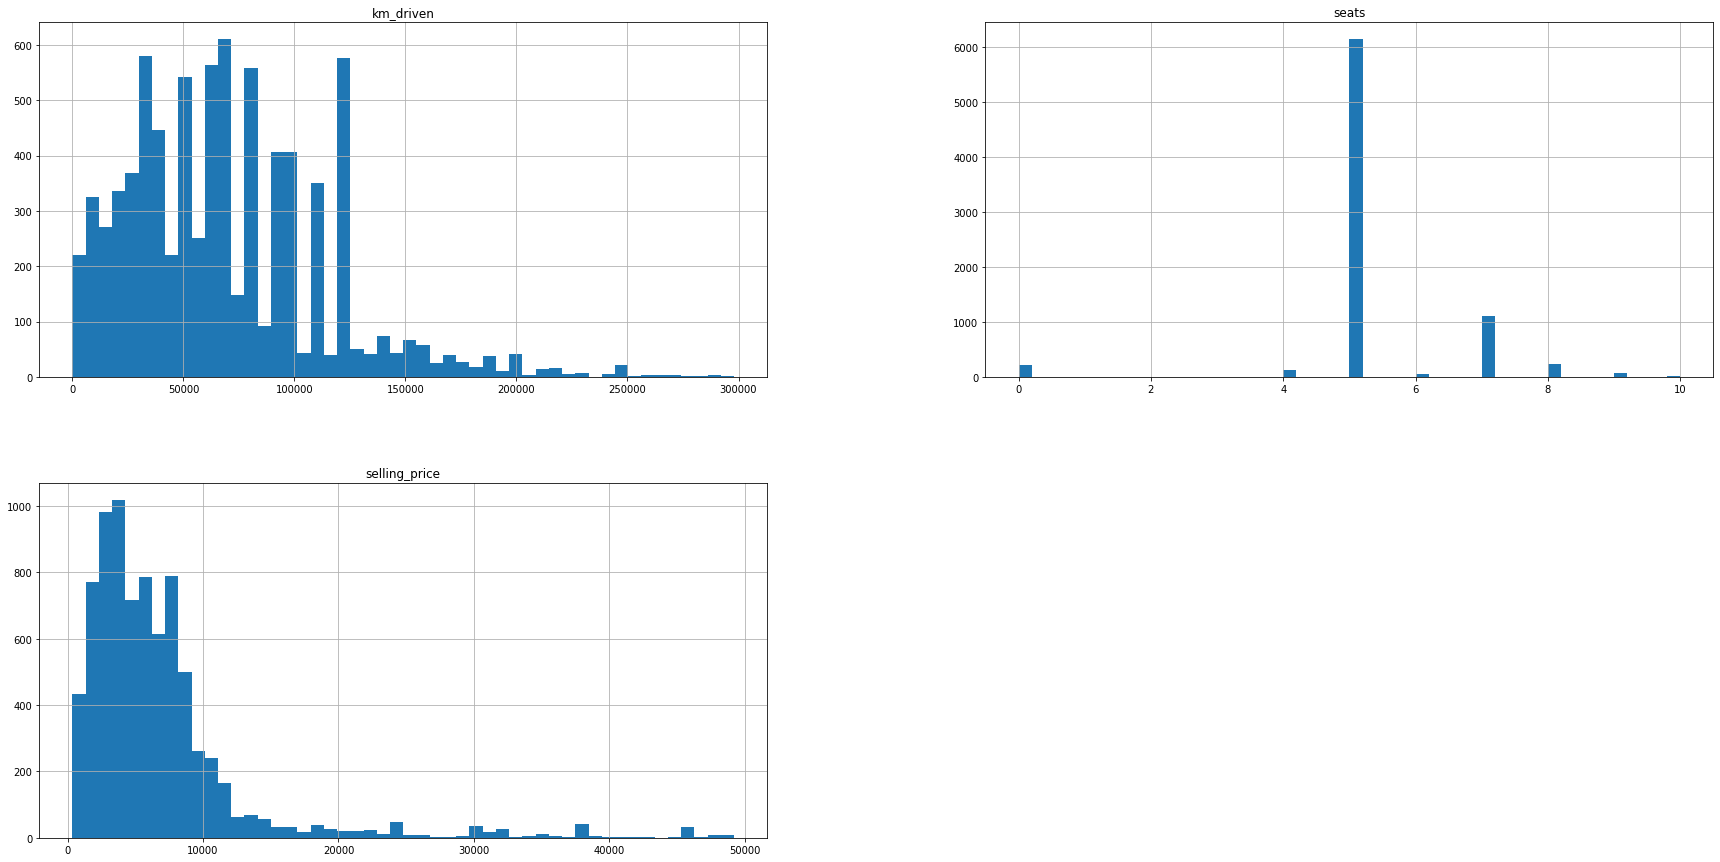

In [16]:
data3 = data3[(data3["km_driven"] < 300000) & (data3["selling_price"] < 50000) & (data3["seats"] < 12)]
%matplotlib inline
data3[["selling_price", "km_driven", "seats"]].hist(bins=50, figsize=(30,15))
plt.show()

### Correlación

In [17]:
data3.corr()

,year,selling_price,km_driven,owner,seats,mileage_num,engine_num,max_power_num,torque_num,torque_rpm,Automatic,Manual,CNG,Diesel,LPG,Petrol,Dealer,Individual,Trustmark Dealer,Ambassador,Ashok,Audi,BMW,Chevrolet,Daewoo,Datsun,Fiat,Force,Ford,Honda,Hyundai,Isuzu,Jaguar,Jeep,Kia,Land,Lexus,MG,Mahindra,Maruti,Mercedes-Benz,Mitsubishi,Nissan,Opel,Peugeot,Renault,Skoda,Tata,Toyota,Volkswagen,Volvo
year,1.00,-0.45,0.49,0.51,-0.18,-0.42,-0.11,-0.27,-0.27,-0.34,-0.21,0.21,-0.02,-0.05,0.07,0.04,-0.18,0.22,-0.11,0.06,0.00,-0.02,0.00,0.07,0.06,-0.07,0.03,-0.02,-0.02,-0.04,-0.01,-0.03,-0.07,-0.06,-0.03,0.00,nan,-0.03,-0.01,0.06,0.01,0.05,-0.01,0.04,0.05,-0.09,0.00,0.05,0.02,-0.01,-0.10
selling_price,-0.45,1.00,-0.25,-0.27,0.16,-0.05,0.48,0.71,0.60,0.01,0.55,-0.55,-0.04,0.27,-0.05,-0.26,0.30,-0.31,0.08,-0.02,-0.01,0.22,0.22,-0.09,-0.02,-0.04,-0.04,0.02,-0.02,0.01,-0.09,0.06,0.41,0.18,0.04,0.04,nan,0.04,0.04,-0.20,0.19,0.02,-0.02,-0.01,-0.01,-0.03,0.01,-0.12,0.19,-0.02,0.42
km_driven,0.49,-0.25,1.00,0.34,0.12,-0.21,0.20,-0.04,0.03,-0.37,-0.21,0.21,-0.00,0.34,0.02,-0.35,-0.18,0.22,-0.11,0.01,0.03,-0.02,-0.02,0.04,0.01,-0.07,0.03,-0.01,0.02,-0.05,-0.07,-0.01,-0.08,-0.04,-0.03,0.00,nan,-0.02,0.12,-0.08,-0.02,0.07,0.01,0.01,0.01,-0.04,0.00,0.08,0.16,0.01,-0.11
owner,0.51,-0.27,0.34,1.00,-0.07,-0.21,-0.04,-0.13,-0.14,-0.22,-0.13,0.13,0.01,0.01,0.03,-0.02,-0.19,0.21,-0.08,0.02,0.01,-0.01,-0.00,0.06,-0.01,-0.04,0.01,-0.01,-0.01,-0.04,0.02,-0.02,-0.06,-0.04,-0.01,0.01,nan,-0.01,-0.00,0.03,-0.00,0.01,-0.00,0.02,0.02,-0.05,-0.01,0.00,0.01,0.02,-0.06
seats,-0.18,0.16,0.12,-0.07,1.00,0.17,0.72,0.44,0.39,0.13,-0.01,0.01,-0.04,0.27,-0.04,-0.26,-0.03,0.03,-0.00,-0.00,0.02,0.00,-0.03,0.07,-0.00,0.01,-0.05,0.02,-0.05,-0.03,-0.16,0.02,-0.02,-0.01,-0.00,-0.00,nan,-0.00,0.41,-0.15,-0.01,0.03,-0.02,-0.00,-0.05,-0.01,-0.02,0.02,0.14,-0.04,-0.02
mileage_num,-0.42,-0.05,-0.21,-0.21,0.17,1.00,-0.14,-0.03,0.05,0.25,-0.11,0.11,0.06,0.07,-0.03,-0.08,0.03,-0.02,-0.01,-0.03,0.00,-0.04,-0.02,-0.02,-0.00,0.04,-0.03,-0.01,0.03,0.04,0.01,-0.03,-0.04,-0.04,-0.00,-0.04,nan,-0.02,-0.22,0.26,-0.09,-0.04,0.01,-0.01,-0.04,0.10,-0.04,-0.03,-0.24,0.01,-0.03
engine_num,-0.11,0.48,0.20,-0.04,0.72,-0.14,1.00,0.75,0.62,-0.05,0.23,-0.23,-0.06,0.47,-0.06,-0.45,0.08,-0.10,0.05,0.02,0.00,0.10,0.09,-0.00,-0.02,-0.05,-0.04,0.05,0.02,0.02,-0.16,0.06,0.12,0.09,0.00,0.02,nan,0.00,0.39,-0.41,0.12,0.07,0.00,0.00,-0.03,-0.07,0.04,0.04,0.31,0.01,0.09
max_power_num,-0.27,0.71,-0.04,-0.13,0.44,-0.03,0.75,1.00,0.72,0.12,0.45,-0.45,-0.08,0.30,-0.06,-0.28,0.20,-0.21,0.05,-0.02,-0.00,0.20,0.22,-0.02,-0.02,-0.06,-0.03,0.02,0.01,0.10,-0.05,0.05,0.25,0.18,0.02,0.03,nan,0.03,0.10,-0.35,0.20,0.05,-0.00,-0.00,-0.03,-0.05,0.05,-0.00,0.14,0.04,0.21
torque_num,-0.27,0.60,0.03,-0.14,0.39,0.05,0.62,0.72,1.00,0.03,0.28,-0.28,-0.07,0.55,-0.06,-0.53,0.15,-0.12,-0.02,-0.01,0.00,0.13,0.12,0.01,-0.02,-0.05,0.01,0.03,0.02,-0.03,-0.22,-0.01,0.27,0.11,-0.03,0.04,nan,0.02,0.26,-0.21,0.13,0.03,0.02,-0.00,-0.02,-0.01,0.01,0.03,0.04,0.06,0.20
torque_rpm,-0.34,0.01,-0.37,-0.22,0.13,0.25,-0.05,0.12,0.03,1.00,0.13,-0.13,0.01,-0.54,-0.02,0.54,0.04,-0.12,0.18,-0.01,-0.00,-0.00,-0.03,0.01,0.01,0.10,-0.05,-0.01,-0.04,0.13,0.11,0.00,-0.03,0.00,-0.00,-0.01,nan,0.01,-0.11,0.01,-0.03,-0.05,0.00,0.00,-0.03,0.05,-0.01,-0.07,-0.06,0.01,-0.10


Las variables que tienen más correlación con la variable objetivo por si mismas son potencia, par motor, cilindrada
y edad del coche.
Se comprueba que las marcas de coche más caras tienen una correlación directa con el precio de venta.
No vamos a eliminar ninguna variable por tener poca correlación, porque este es un problema en el que pesa mucho la combinación de variables.

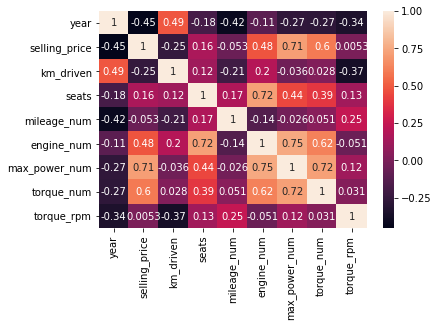

In [18]:
# Another way to see it (Quantitative features)
corr_matrix = data3[["year", "selling_price", "km_driven", "seats", "mileage_num", "engine_num", "max_power_num",
       "torque_num", "torque_rpm"]].corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

#### Train/Test y normalizar

In [25]:
X = data3.drop(["selling_price"], axis=1).to_numpy()
y = data3["selling_price"].to_numpy()

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X =scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Train: " + str(len(X_train)))
print("Test: " + str(len(X_test)))

Train: 6381
Test: 1596


### Modelos

#### Exploración

In [22]:
models = {"LR":LinearRegression(),
         "KNNR":KNeighborsRegressor(),
         "SVR":SVR(kernel="linear" ),
         "DT":DecisionTreeRegressor(),
         "RF":RandomForestRegressor()
         }

In [23]:
for name,model in models.items():
    print(f'Model:{name}')
    model.fit(X_train,y_train)
    print(f'training score:{round(model.score(X_train, y_train) * 100, 2)}')
    print(f'test score:{round(model.score(X_test,y_test)*100,2)}')
    y_pred =model.predict(X_test)
    print(f'RMSE:{np.sqrt(mean_squared_error(y_test,y_pred))}')
    print(' ')

Model:LR
training score:83.83
test score:83.8
RMSE:2672.8937404694475
 
Model:KNNR
training score:93.9
test score:90.74
RMSE:2020.950449403924
 
Model:SVR
training score:68.51
test score:67.32
RMSE:3796.3554206963945
 
Model:DT
training score:99.93
test score:92.32
RMSE:1840.4151598237954
 
Model:RF


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


training score:99.04
test score:95.36
RMSE:1430.8867598242011
 


Escogemos Random Forest Regressor por ser el que mejor resultado presenta en test, y menor RMSE. 
A pesar de que hace overfitting en train.

### Random Forest Regressor

#### Grid Search

In [26]:
param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 30}


Entrenamos el modelo con los mejores parámetros obtenidos en el grid search

In [29]:
model = RandomForestRegressor(bootstrap=False, max_features="sqrt", min_samples_split=4, n_estimators=30)
model.fit(X_train, y_train)

print(f'training score:{round(model.score(X_train, y_train) * 100, 2)}')
print(f'test score:{round(model.score(X_test,y_test)*100,2)}')
y_pred =model.predict(X_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test,y_pred))}')

training score:99.57
test score:96.15
RMSE:1302.2966085945834


### Guardar el modelo

In [32]:
filename = 'car_price_estimator.sav'
pickle.dump(model, open(filename, 'wb'))